In [64]:
import glob
# This file should run basically insta fast. Bad coding for sure 
# There is a place where i sometimes comment out lin/rbf/sigmoid stuff
# Dont do that, it really helps for some subjects. 
# Anything. Leave only linear. For fast testing of best features
# But dont do that either. 

genSavePath = "F:/PythonProjects/NietoExcercise-1/SavedResults/"
day = "14" # Which month and days result you want to visualize in table
month = 11

repetitionValue = 94
repetitionName =  "udrli5withAnovabothBCKinds"#  "udrli1feattestanglnoBC"  # "udrliplotnoAda3"  #  "udrlBC4CVTest" # 
#  "udrliplotnoAda3hyperparams" 
repetitionString = f"{repetitionValue}{repetitionName}"
curSavePath = f"{genSavePath}{day}-{month}-{repetitionString}/"
savedResults = glob.glob(curSavePath + "savedBestSeed*")

saveTop = False
if saveTop:
    saveTopName = "top4udrli.npy"
else:
    saveTopName = None
topAmount = 20
skipSubjects = []
onlySignificant = True
minAcc = 0.1
print(len(savedResults))
print(len(savedResults)/9)

90
10.0


In [65]:
import pandas as pd
from array import ArrayType
from requests import delete
import numpy as np


nameDict = dict()
nrOfNames = 0
kernelDict = dict()
nrOfKernel = 0
nrOfCombination = 0
currSeed = 0
currSubj = 0
combinationList = []
combinationResult = []


results = []
for path in savedResults:
    results.append(np.load(path, allow_pickle=True))

subjectAmount = 10
for x in range(subjectAmount):
    combinationResult.append([])

nrOfSeedsPerSubject = np.zeros(subjectAmount)
for s, subject in enumerate(results):
    currSubj = 0
    currSeed = 0
    subjectBestArray = np.empty([len(subject)], dtype=object)

    currSeed = subject[0]
    currSubj = subject[1]

    if currSubj in skipSubjects:
        continue
    nrOfSeedsPerSubject[currSubj] += 1

    for aResults in subject[2]:
        for aResults2 in aResults:
            # If the np array comes from svm results
            if len(aResults2) < 6:

                aName = aResults2[0]
                ares = aResults2[1]

                if type(ares) is tuple:
                    ares = ares[0]
                if ares > 0.98:
                    ares = 0.99
                akernel = aResults2[2]
                
                
                # if "lin" in akernel:
                #     continue
                # if "sig" in akernel:
                #     continue
                aC = round(aResults2[3], 2)

                if aName not in nameDict:
                    nameDict[aName] = nrOfNames
                    nrOfNames += 1
                if akernel not in kernelDict:
                    kernelDict[akernel] = nrOfKernel
                    nrOfKernel += 1
                if [nameDict[aName], kernelDict[akernel], aC] not in combinationList:
                    combinationList.append([nameDict[aName], kernelDict[akernel], aC])
                    nrOfCombination += 1

                combNr = combinationList.index(
                    [nameDict[aName], kernelDict[akernel], aC]
                )
                if any(combNr in sublist for sublist in combinationResult[currSubj]):
                    sublist = np.array(combinationResult[currSubj])
                    
                    index = int(np.where(sublist[:, 0] == combNr)[0])

                    combinationResult[currSubj][index][1] = combinationResult[currSubj][
                        index
                    ][1] * (1 - (1 / nrOfSeedsPerSubject[currSubj])) + ares * (
                        1 / nrOfSeedsPerSubject[currSubj]
                    )

                else:

                    combinationResult[currSubj].append([combNr, ares])

                    # If the np array comes from NN results
            else:

                aName = aResults2[0]
                ares = aResults2[1]

                if type(ares) is tuple:
                    ares = ares[0]
                akernel = aResults2[2]
                aLz = round(aResults2[3], 2)
                areg = round(aResults2[4], 2)
                adrp = round(aResults2[5], 2)
                if aName not in nameDict:
                    nameDict[aName] = nrOfNames
                    nrOfNames += 1
                if akernel not in kernelDict:
                    kernelDict[akernel] = nrOfKernel
                    nrOfKernel += 1
                if [
                    nameDict[aName],
                    kernelDict[akernel],
                    aLz,
                    areg,
                    adrp,
                ] not in combinationList:
                    combinationList.append(
                        [nameDict[aName], kernelDict[akernel], aLz, areg, adrp]
                    )
                    nrOfCombination += 1
                # combResult = []
                combNr = combinationList.index(
                    [nameDict[aName], kernelDict[akernel], aLz, areg, adrp]
                )
                if any(combNr in sublist for sublist in combinationResult[currSubj]):
                    sublist = np.array(combinationResult[currSubj])
                  
                    index = int(np.where(sublist[:, 0] == combNr)[0])

                    combinationResult[currSubj][index][1] = combinationResult[currSubj][
                        index
                    ][1] * (1 - (1 / nrOfSeedsPerSubject[currSubj])) + ares * (
                        1 / nrOfSeedsPerSubject[currSubj]
                    )

                else:

                    combinationResult[currSubj].append([combNr, ares])


# Making table

# headers = [f"{x[0]}:{x[1]}:{x[2]}:" for x in combinationList]
headers = np.arange(nrOfCombination)
subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
subjectNrList = []

comboAverage = np.zeros([1, nrOfCombination])
comboTotal = np.zeros([1, nrOfCombination])
nrOfSubjects = np.zeros(nrOfCombination)

topTen = []
topThreeAllSubjects = []
nameArray = np.array(list(nameDict))
topPerFeature = np.zeros([10, len(nameDict)])
lowestTopRes = [0, 0]
for subNr, cResult in enumerate(combinationResult):
    topThreeThisSubject = []
    resArray = np.zeros([nrOfCombination])
    if len(cResult) != 0:
        for res in cResult:
            if onlySignificant == True:
                if res[1] < minAcc:
                    continue
            comboAverage[0, res[0]] = comboAverage[0, res[0]] + res[1]
            comboTotal[0, res[0]] = comboTotal[0, res[0]] + res[1]
            nrOfSubjects[res[0]] += 1
            subjectResultArray[subNr, res[0]] = res[1]
            
            comboName = list(nameDict.keys())[combinationList[res[0]][0]]
            nameIndex = np.where(nameArray == comboName)[0][0]
            if res[1] > topPerFeature[subNr, nameIndex]:
                topPerFeature[subNr, nameIndex] = res[1]

            if len(topTen) < 10 or topTen[0][0] < res[1]:

                if len(topTen) == 10:
                    topTen.reverse()
                    topTen.pop()

                dataF = list(nameDict.keys())[combinationList[res[0]][0]]
                kernel = list(kernelDict.keys())[combinationList[res[0]][1]]
                cVal = combinationList[res[0]][2]
                topTen.append([res[1], subNr, dataF, kernel, cVal])
                topTen.sort()

            
            
            if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                if len(topThreeThisSubject) == 2:
                    topThreeThisSubject.reverse()
                    topThreeThisSubject.pop()

                dataF = list(nameDict.keys())[combinationList[res[0]][0]]
                kernel = list(kernelDict.keys())[combinationList[res[0]][1]]
                cVal = combinationList[res[0]][2]
                topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                topThreeThisSubject.sort()
    if len(topThreeThisSubject)>0:
        topThreeAllSubjects.append(topThreeThisSubject)
# Print the table!
comboAverage = comboAverage / nrOfSubjects
print(comboAverage.shape)
print(subjectResultArray.shape)
pd.set_option("display.max_columns", None)

# For loop through zip of headers and columns,
# If column has all values == None, Remove column and header.
subjectResultArray = np.array(subjectResultArray)
emptyCols = []
atleastOneEmpty = False
for hcol, in zip(headers):
    if all(subjectResultArray[:,hcol] == None):
        atleastOneEmpty = True
        emptyCols.append(hcol)
if atleastOneEmpty: 
    subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
    headers = np.delete(headers, np.array(emptyCols),0)
    comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
    comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
    nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)


table = pd.DataFrame(subjectResultArray, columns=headers)
display(table)




(1, 783)
(10, 783)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782
0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,

In [66]:
x = 0

pd.set_option("display.max_columns", None)
print()
nameDictNrs = np.ones([1, len(nameDict)])
nameDictNrs[0,:] = np.arange(len(nameDict)) * 3
print(nameDictNrs.shape)
#table = pd.DataFrame(nameDictNrs , columns=nameDict.keys())
table = pd.DataFrame(topPerFeature, columns=nameDict.keys())
#display(table)
display(table)



(1, 261)


,dataFFTCV-BC-dataGCV-BCcn3-fftDataBC-dataCorr1dcn3BC--6dataCorr2ax1dBC,dataFFTCV-BC-dataGCVBC-fftDataBC-6dataCorr2ax1dBC--dataGCVBC,dataFFTCV-BC-inverseFFTCV-BC-fftDataBC-welchDataBC--dataCorr1dcn3BC,dataFFTCV-BC-dataGCV-BCcn3-fftDataBC-dataCorr1dcn3BC--gaussianDataBC,dataFFTCV-BC-dataHRCV-BC-fftDataBC-welchDataBC--iFFTdataCorr2ax1d005s-BC,dataFFTCV-BC-dataCorr1dBC-fftDataBC-welchDataBC--dataCorr1dBC,dataFFTCV-BC-dataFFTCV-BC-fftDataBC-iFFTdataCorr1d01s-BC--dataFFTCV-BC,dataFFTCV-BC-dataCorr1dBC-fftDataBC-welchDataBC--1dataCorr2ax1dBC,dataFFTCV-BC-dataGCV-BCcn3-fftDataBC-welchDataBC--dataHRCV-BC,dataHRCV-BC-dataGCV-BCcn3-fftDataBC-dataCorr1dcn3BC--6dataCorr2ax1dBC,dataHRCV-BC-dataGCVBC-fftDataBC-6dataCorr2ax1dBC--dataGCVBC,dataHRCV-BC-inverseFFTCV-BC-fftDataBC-welchDataBC--dataCorr1dcn3BC,dataHRCV-BC-dataGCV-BCcn3-fftDataBC-dataCorr1dcn3BC--gaussianDataBC,dataHRCV-BC-dataHRCV-BC-fftDataBC-welchDataBC--iFFTdataCorr2ax1d005s-BC,dataHRCV-BC-dataCorr1dBC-fftDataBC-welchDataBC--dataCorr1dBC,dataHRCV-BC-dataFFTCV-BC-fftDataBC-iFFTdataCorr1d01s-BC--dataFFTCV-BC,dataHRCV-BC-dataCorr1dBC-fftDataBC-welchDataBC--1dataCorr2ax1dBC,dataHRCV-BC-dataGCV-BCcn3-fftDataBC-welchDataBC--dataHRCV-BC,fftDataBC-dataGCV-BCcn3-fftDataBC-dataCorr1dcn3BC--6dataCorr2ax1dBC,fftDataBC-dataGCVBC-fftDataBC-6dataCorr2ax1dBC--dataGCVBC,fftDataBC-inverseFFTCV-BC-fftDataBC-welchDataBC--dataCorr1dcn3BC,fftDataBC-dataGCV-BCcn3-fftDataBC-dataCorr1dcn3BC--gaussianDataBC,fftDataBC-dataHRCV-BC-fftDataBC-welchDataBC--iFFTdataCorr2ax1d005s-BC,fftDataBC-dataCorr1dBC-fftDataBC-welchDataBC--dataCorr1dBC,fftDataBC-dataFFTCV-BC-fftDataBC-iFFTdataCorr1d01s-BC--dataFFTCV-BC,fftDataBC-dataCorr1dBC-fftDataBC-welchDataBC--1dataCorr2ax1dBC,fftDataBC-dataGCV-BCcn3-fftDataBC-welchDataBC--dataHRCV-BC,welchDataBC-dataGCV-BCcn3-fftDataBC-dataCorr1dcn3BC--6dataCorr2ax1dBC,welchDataBC-dataGCVBC-fftDataBC-6dataCorr2ax1dBC--dataGCVBC,welchDataBC-inverseFFTCV-BC-fftDataBC-welchDataBC--dataCorr1dcn3BC,welchDataBC-dataGCV-BCcn3-fftDataBC-dataCorr1dcn3BC--gaussianDataBC,welchDataBC-dataHRCV-BC-fftDataBC-welchDataBC--iFFTdataCorr2ax1d005s-BC,welchDataBC-dataCorr1dBC-fftDataBC-welchDataBC--dataCorr1dBC,welchDataBC-dataFFTCV-BC-fftDataBC-iFFTdataCorr1d01s-BC--dataFFTCV-BC,welchDataBC-dataCorr1dBC-fftDataBC-welchDataBC--1dataCorr2ax1dBC,welchDataBC-dataGCV-BCcn3-fftDataBC-welchDataBC--dataHRCV-BC,dataHRBC-dataGCV-BCcn3-fftDataBC-dataCorr1dcn3BC--6dataCorr2ax1dBC,dataHRBC-dataGCVBC-fftDataBC-6dataCorr2ax1dBC--dataGCVBC,dataHRBC-inverseFFTCV-BC-fftDataBC-welchDataBC--dataCorr1dcn3BC,dataHRBC-dataGCV-BCcn3-fftDataBC-dataCorr1dcn3BC--gaussianDataBC,dataHRBC-dataHRCV-BC-fftDataBC-welchDataBC--iFFTdataCorr2ax1d005s-BC,dataHRBC-dataCorr1dBC-fftDataBC-welchDataBC--dataCorr1dBC,dataHRBC-dataFFTCV-BC-fftDataBC-iFFTdataCorr1d01s-BC--dataFFTCV-BC,dataHRBC-dataCorr1dBC-fftDataBC-welchDataBC--1dataCorr2ax1dBC,dataHRBC-dataGCV-BCcn3-fftDataBC-welchDataBC--dataHRCV-BC,dataGCVBC-dataGCV-BCcn3-fftDataBC-dataCorr1dcn3BC--6dataCorr2ax1dBC,dataGCVBC-dataGCVBC-fftDataBC-6dataCorr2ax1dBC--dataGCVBC,dataGCVBC-inverseFFTCV-BC-fftDataBC-welchDataBC--dataCorr1dcn3BC,dataGCVBC-dataGCV-BCcn3-fftDataBC-dataCorr1dcn3BC--gaussianDataBC,dataGCVBC-dataHRCV-BC-fftDataBC-welchDataBC--iFFTdataCorr2ax1d005s-BC,dataGCVBC-dataCorr1dBC-fftDataBC-welchDataBC--dataCorr1dBC,dataGCVBC-dataFFTCV-BC-fftDataBC-iFFTdataCorr1d01s-BC--dataFFTCV-BC,dataGCVBC-dataCorr1dBC-fftDataBC-welchDataBC--1dataCorr2ax1dBC,dataGCVBC-dataGCV-BCcn3-fftDataBC-welchDataBC--dataHRCV-BC,gaussianDataBC-dataGCV-BCcn3-fftDataBC-dataCorr1dcn3BC--6dataCorr2ax1dBC,gaussianDataBC-dataGCVBC-fftDataBC-6dataCorr2ax1dBC--dataGCVBC,gaussianDataBC-inverseFFTCV-BC-fftDataBC-welchDataBC--dataCorr1dcn3BC,gaussianDataBC-dataGCV-BCcn3-fftDataBC-dataCorr1dcn3BC--gaussianDataBC,gaussianDataBC-dataHRCV-BC-fftDataBC-welchDataBC--iFFTdataCorr2ax1d005s-BC,gaussianDataBC-dataCorr1dBC-fftDataBC-welchDataBC--dataCorr1dBC,gaussianDataBC-dataFFTCV-BC-fftDataBC-iFFTdataCorr1d01s-BC--dataFFTCV-BC,

In [67]:
for names in nameDict.keys():
    print(names)
    x +=1
    #print(x)


dataFFTCV-BC-dataGCV-BCcn3-fftDataBC-dataCorr1dcn3BC--6dataCorr2ax1dBC
dataFFTCV-BC-dataGCVBC-fftDataBC-6dataCorr2ax1dBC--dataGCVBC
dataFFTCV-BC-inverseFFTCV-BC-fftDataBC-welchDataBC--dataCorr1dcn3BC
dataFFTCV-BC-dataGCV-BCcn3-fftDataBC-dataCorr1dcn3BC--gaussianDataBC
dataFFTCV-BC-dataHRCV-BC-fftDataBC-welchDataBC--iFFTdataCorr2ax1d005s-BC
dataFFTCV-BC-dataCorr1dBC-fftDataBC-welchDataBC--dataCorr1dBC
dataFFTCV-BC-dataFFTCV-BC-fftDataBC-iFFTdataCorr1d01s-BC--dataFFTCV-BC
dataFFTCV-BC-dataCorr1dBC-fftDataBC-welchDataBC--1dataCorr2ax1dBC
dataFFTCV-BC-dataGCV-BCcn3-fftDataBC-welchDataBC--dataHRCV-BC
dataHRCV-BC-dataGCV-BCcn3-fftDataBC-dataCorr1dcn3BC--6dataCorr2ax1dBC
dataHRCV-BC-dataGCVBC-fftDataBC-6dataCorr2ax1dBC--dataGCVBC
dataHRCV-BC-inverseFFTCV-BC-fftDataBC-welchDataBC--dataCorr1dcn3BC
dataHRCV-BC-dataGCV-BCcn3-fftDataBC-dataCorr1dcn3BC--gaussianDataBC
dataHRCV-BC-dataHRCV-BC-fftDataBC-welchDataBC--iFFTdataCorr2ax1d005s-BC
dataHRCV-BC-dataCorr1dBC-fftDataBC-welchDataBC--dataCorr1dBC

(261,)
[  5  23  50  19  32  14  68  28  25   7  52   1  46  64  70 140 194 131
 185 212  34   4  10 205 176  24  16 149 203  20  49 181 202 167  22 113
 199  95 178  71 221  67 127  13  59 196  69 206  55  18  86 193  35 104
 250  61  26 224 190  27 204  33 142  82 184 115 230 187 244 251  53 133
 239 208  31 217 223 226 172  17  30 214   8  65  97 247 248  88 151  21
 232 130 169 136   2 116  58  47 163 139 166 109  11  60 124 186   9 122
  29 107 100 241 182  91 215  89 137 188  51 229   6 211 209 197 119 200
  56 121 125 175 106  98 179 240 143 213 145 173 222 150 118 249 170 152
  77 235 112  62 164 233 128 191 231 192  80 238 134 141  45 132 123 242
 110 180 148  12  85 177  63   0 103 207  94 220  48  79 218 198  66   3
  15  81 236 189 101 195 144 126 245 227  83  93 146  99  54 201 135  73
 147  57  87 102  90 162 168 114 171 108  74 183 174  84 165 105 210 243
 234 120 111 117 138 246  44  96 228 219 129  43 216  92  41  72 225 237
  75  76  78  40  36  39  42  37  38 155 158

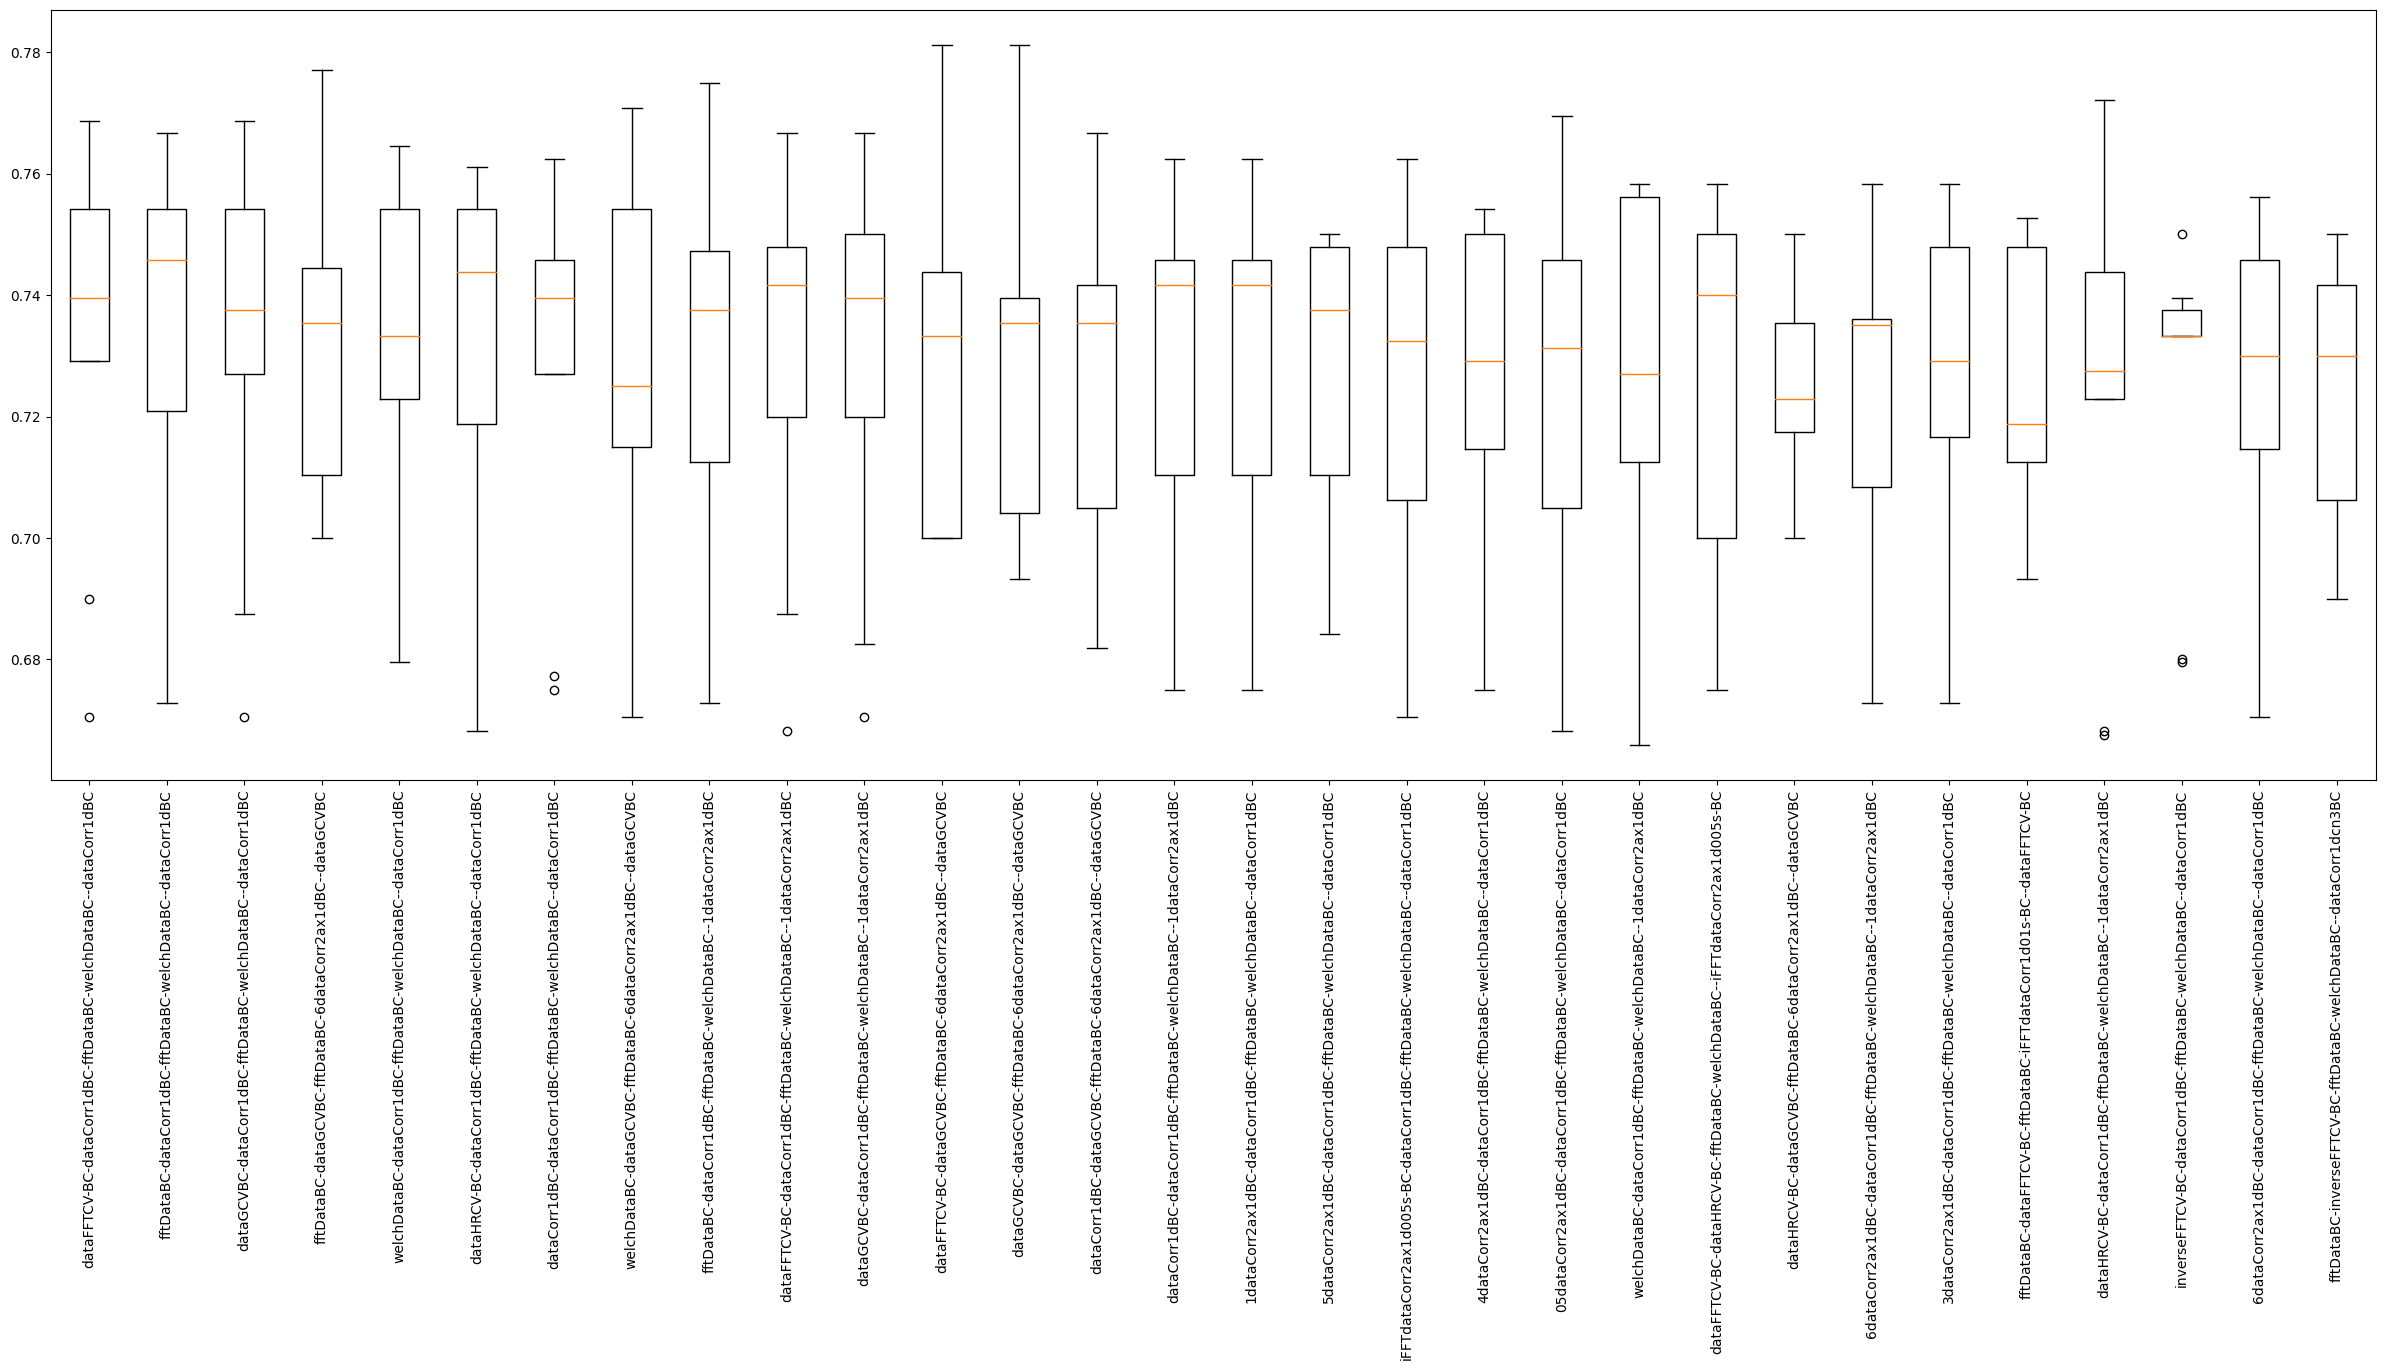

In [80]:
import matplotlib.pyplot as plt
# ordeTopAverage = np.array(np.argsort(comboAverage, axis=1)/(len(combinationList))*len(dataF),dtype=int)
# print(ordeTopAverage)
# print(len(combinationList))
# print(len(dataF))
# print(len(topPerFeature))
# print(len(combinationList)/len(dataF))
#print(ordeTopAverage)
meanTop = np.mean(topPerFeature[1:], axis=0)
print(meanTop.shape)
indices = np.argsort(meanTop, axis=0)[::-1]
print(indices)
#indices = np.argsort(topPerFeature[1:], axis=1)[:,::-1][1,:]

#topPerFeature = np.sort(topPerFeature, axis=1)[:,::-1]
#topPerFeature = np.sort(topPerFeature, axis=1)[:,::-1]




print(indices.shape)

#np.argsort(comboAverage, axis=1)
#sortA = np.argsort(topPerFeature, axis = 1)
if len(nameArray) < 50:
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:30])
    plt.xticks(np.arange(len(nameArray[indices][:30]))+1,nameArray[indices][:30],rotation=45)
    #plt.legend(nameArray)
    print("")
    # plt.figure(figsize=[30,10])
    # plt.boxplot(topPerFeature[1:][:])
    # plt.xticks(np.arange(len(nameArray))+1,nameArray,rotation=45)
    # #plt.legend(nameArray)
    # print("")
else: 
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:30])
    plt.xticks(np.arange(len(nameArray[indices][:30]))+1,nameArray[indices][:30],rotation=90)
    #plt.legend(nameArray)
    print("")
    


In [69]:
print("Top ten highest accuracies")

topTen.reverse()
for top in topTen:
    print(
            f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
        )


Top ten highest accuracies
Accuracy 0.78 : subject 4, feature:dataGCVBC-dataGCVBC-fftDataBC-6dataCorr2ax1dBC--dataGCVBC, kernelrbf, C:2.5
Accuracy 0.78 : subject 4, feature:dataFFTCV-BC-dataGCVBC-fftDataBC-6dataCorr2ax1dBC--dataGCVBC, kernelrbf, C:2.5
Accuracy 0.78 : subject 8, feature:dataHRCV-BC-inverseFFTCV-BC-fftDataBC-welchDataBC--dataCorr1dcn3BC, kernellinear, C:2.5
Accuracy 0.78 : subject 4, feature:fftDataBC-dataGCVBC-fftDataBC-6dataCorr2ax1dBC--dataGCVBC, kernelrbf, C:2.5
Accuracy 0.78 : subject 5, feature:fftDataBC-dataGCV-BCcn3-fftDataBC-dataCorr1dcn3BC--6dataCorr2ax1dBC, kernelsigmoid, C:2.5
Accuracy 0.78 : subject 4, feature:fftDataBC-dataCorr1dBC-fftDataBC-welchDataBC--1dataCorr2ax1dBC, kernelrbf, C:2.5
Accuracy 0.77 : subject 3, feature:05dataCorr2ax1dBC-dataHRCV-BC-fftDataBC-welchDataBC--iFFTdataCorr2ax1d005s-BC, kernelsigmoid, C:2.5
Accuracy 0.77 : subject 3, feature:dataHRCV-BC-dataCorr1dBC-fftDataBC-welchDataBC--1dataCorr2ax1dBC, kernelsigmoid, C:2.5
Accuracy 0.77 : 

In [70]:
# top for each feature

In [71]:
print("Top ten highest accuracies")
#del(topThreeThisSubject[0])
#len(topThreeAllSubjects[0])
for subTop in topThreeAllSubjects:
    subTop.reverse()
topThreeAllSubjects.sort(reverse=True)
arrayOfTopFeatureNames = []
for subTop in topThreeAllSubjects:
    print("")
    #subTop.reverse()
    for top in subTop[:1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )
#print(arrayOfTopFeatureNames)
arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
#print(np.array(arrayOfTopFeatureNames, dtype=object).shape)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    temp = topNames.replace("--","-")
    temp2 = temp.replace("-B","%")
    splitArray = np.array(temp2.split("-"),dtype=object)
    for ind, stri in enumerate(splitArray):
        splitArray[ind] = stri.replace("%","-B")
    skip = False  
    for obj in splitArray:
        #print(obj)
        if obj == "":
            #print("aofafa")
            skip = True
    if skip:
        continue
    #print(splitArray)
    newArrayOfTopFeatureNames.append(splitArray)
    
#print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
#saveTopName = "top2udrli"
if saveTopName is not None:
    #print(newArrayOfTopFeatureNames)
    np.save(f"topFeatures/{saveTopName}", newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    print(newArrayOfTopFeatureNames)


Top ten highest accuracies

Accuracy 0.78 : subject 4, feature:dataGCVBC-dataGCVBC-fftDataBC-6dataCorr2ax1dBC--dataGCVBC, kernelrbf, C:2.5

Accuracy 0.78 : subject 8, feature:dataHRCV-BC-inverseFFTCV-BC-fftDataBC-welchDataBC--dataCorr1dcn3BC, kernellinear, C:2.5

Accuracy 0.78 : subject 5, feature:fftDataBC-dataGCV-BCcn3-fftDataBC-dataCorr1dcn3BC--6dataCorr2ax1dBC, kernelsigmoid, C:2.5

Accuracy 0.77 : subject 3, feature:05dataCorr2ax1dBC-dataHRCV-BC-fftDataBC-welchDataBC--iFFTdataCorr2ax1d005s-BC, kernelsigmoid, C:2.5

Accuracy 0.76 : subject 9, feature:dataFFTCV-BC-dataGCV-BCcn3-fftDataBC-dataCorr1dcn3BC--gaussianDataBC, kernelsigmoid, C:2.5

Accuracy 0.75 : subject 2, feature:dataGCVBC-dataCorr1dBC-fftDataBC-welchDataBC--1dataCorr2ax1dBC, kernelsigmoid, C:2.5

Accuracy 0.74 : subject 7, feature:dataHRCV-BC-dataHRCV-BC-fftDataBC-welchDataBC--iFFTdataCorr2ax1d005s-BC, kernelsigmoid, C:2.5

Accuracy 0.73 : subject 1, feature:dataCorr1dBC-dataFFTCV-BC-fftDataBC-iFFTdataCorr1d01s-BC--dat

In [72]:
subjAv = np.zeros(subjectResultArray.shape[0])
for s, subj in enumerate(subjectResultArray):
    subjAv[s] = 0
    if all(subj == None):
        continue
    subjAv[s] = np.mean(subj[np.where(subj != None)])
print(subjAv)
pd.set_option("display.max_columns", None)
table = pd.DataFrame(np.array(comboAverage), columns=headers)
display(table)

print(
    f"Max average accuracy {np.max(np.array(comboAverage[np.where(np.isnan(comboAverage)==False)]))}"
)
maxVal = np.max(np.array(comboAverage[np.where(np.isnan(comboAverage) == False)]))
maxInd = int(np.where(comboAverage == maxVal)[1][0])
# print(headers[maxInd])
# print(nrOfSubjects[maxInd])
# print(list(nameDict.keys())[combinationList[maxInd][0]])
# print(list(kernelDict.keys())[combinationList[maxInd][1]])
# print(f"C: {combinationList[maxInd][2]}")


[0.         0.67463955 0.69973659 0.72333186 0.73129134 0.73425926
 0.66779577 0.69840624 0.69315773 0.71123084]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782
0,0.69969,0.706577,0.695694,0.720031,0.707489,0.720513,0.71171,0.701806,0.7021,0.699949,0.70297,0.694477,0.719583,0.703699,0.707327,0.718114,0.717705,0.717083,0.710442,0.701385,0.706925,0.71476,0.716773,0.71374,0.710139,0.717332,0.699101,0.705602,0.709718,0.690407,0.716101,0.708981,0.711438,0.713861,0.699423,0.698273,0.699769,0.705448,0.690171,0.717253,0.708618,0.702657,0.720184,0.718255,0.712548,0.707022,0.699644,0.705143,0.715572,0.713887,0.70735,0.710415,0.717128,0.693004,0.712081,0.715405,0.705356,0.718364,0.710262,0.721301,0.715776,0.708117,0.712357,0.708541,0.714393,0.704432,0.71453,0.70352,0.714784,0.724254,0.712764,0.720727,0.71932,0.700557,0.713987,0.718945,0.711951,0.720403,0.713173,0.716122,0.708012,0.703499,0.717649,0.693147,0.716439,0.716633,0.71976,0.708962,0.702692,0.704359,0.701667,0.716496,0.692155,0.710363,0.703956,0.703136,0.711212,0.713931,0.71483,0.711188,0.706016,0.707494,0.714879,0.714638,0.711199,0.713749,0.716587,0.698754,0.683542,0.69051

Max average accuracy 0.724253647586981


In [73]:
#np.argpartition(comboAverage, -4)
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboAverage.argsort()[0][-5:][::-1]]
top5Vals = comboAverage[0][comboAverage.argsort()[0][-5:][::-1]]
for maxInd,res in zip(top5, top5Vals):
    print(list(nameDict.keys())[combinationList[maxInd][0]])
    print(list(kernelDict.keys())[combinationList[maxInd][1]])
    print(res)
    print()

fftDataBC-dataCorr1dBC-fftDataBC-welchDataBC--dataCorr1dBC
linear
0.724253647586981

fftDataBC-dataGCVBC-fftDataBC-6dataCorr2ax1dBC--dataGCVBC
rbf
0.7213005050505051

fftDataBC-dataCorr1dBC-fftDataBC-welchDataBC--dataCorr1dBC
rbf
0.720726711560045

dataFFTCV-BC-dataGCVBC-fftDataBC-6dataCorr2ax1dBC--dataGCVBC
rbf
0.7205134680134679

dataGCVBC-dataGCVBC-fftDataBC-6dataCorr2ax1dBC--dataGCVBC
rbf
0.72040544332211



In [74]:
#np.argpartition(comboAverage, -4)
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboTotal.argsort()[0][-5:][::-1]]
top5Vals = comboTotal[0][comboTotal.argsort()[0][-5:][::-1]] /9
for maxInd,res in zip(top5, top5Vals):
    print(list(nameDict.keys())[combinationList[maxInd][0]])
    print(list(kernelDict.keys())[combinationList[maxInd][1]])
    print(res)
    print()

fftDataBC-dataCorr1dBC-fftDataBC-welchDataBC--dataCorr1dBC
linear
0.724253647586981

fftDataBC-dataGCVBC-fftDataBC-6dataCorr2ax1dBC--dataGCVBC
rbf
0.7213005050505051

fftDataBC-dataCorr1dBC-fftDataBC-welchDataBC--dataCorr1dBC
rbf
0.720726711560045

dataFFTCV-BC-dataGCVBC-fftDataBC-6dataCorr2ax1dBC--dataGCVBC
rbf
0.7205134680134679

dataGCVBC-dataGCVBC-fftDataBC-6dataCorr2ax1dBC--dataGCVBC
rbf
0.72040544332211



In [75]:
table = pd.DataFrame(np.array(comboTotal), columns=headers)
display(table)

maxVal2 = np.max(np.array(comboTotal[np.where(np.isnan(comboTotal) == False)]))

for maxInd2 in np.where(comboTotal == maxVal2)[1]:

    # maxInd2 = int(np.where(comboTotal == maxVal2)[1])
    print(headers[maxInd2])
    print(nrOfSubjects[maxInd2])
    print(
        f"Max total significant accuracy then averaged {maxVal2/nrOfSubjects[maxInd2]} "
    )

    print(list(nameDict.keys())[combinationList[maxInd2][0]])
    print(list(kernelDict.keys())[combinationList[maxInd2][1]])
    print(f"C: {combinationList[maxInd2][2]} ")


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782
0,6.29721,6.359192,6.26125,6.480278,6.367399,6.484621,6.405391,6.31625,6.318902,6.299545,6.32673,6.25029,6.47625,6.333295,6.365947,6.46303,6.459343,6.45375,6.393977,6.312462,6.362323,6.432841,6.45096,6.423662,6.39125,6.455985,6.291907,6.350417,6.387462,6.213662,6.444912,6.380833,6.402942,6.424747,6.294811,6.284457,6.297917,6.349028,6.21154,6.455278,6.377563,6.323914,6.481654,6.464293,6.412929,6.363194,6.296793,6.346288,6.440152,6.424987,6.366149,6.393737,6.454154,6.237033,6.408725,6.438649,6.348207,6.465278,6.392361,6.491705,6.441982,6.373056,6.411212,6.376869,6.429533,6.339886,6.43077,6.331679,6.433056,6.518283,6.414874,6.48654,6.473876,6.305013,6.425884,6.470505,6.407563,6.483624,6.418561,6.445101,6.372109,6.33149,6.458838,6.238321,6.447955,6.449697,6.477841,6.380657,6.32423,6.33923,6.315,6.44846,6.229394,6.39327,6.335606,6.32822,6.400909,6.425379,6.433472,6.400694,6.354141,6.367449,6.433914,6.431742,6.400795,6.423737,6.44928,6.288788,6.151881,6.214596,6.165694

69
9.0
Max total significant accuracy then averaged 0.724253647586981 
fftDataBC-dataCorr1dBC-fftDataBC-welchDataBC--dataCorr1dBC
linear
C: 2.5 


In [76]:
# maxAcc = np.max([res for res in np.array(
#     subjectResultArray[subjectResultArray != None])])
# print(f"Max single accuracy position {np.where(subjectResultArray == maxAcc)}")
# print(np.max([res for res in np.array(
#     subjectResultArray[subjectResultArray != None])]))
